In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import preprocessing

from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings("ignore")

## 1 Імпорт даних

### Список основних подій

<li> <b>Transaction Refund</b> - користувач отримує повернення коштів, оскільки він, ймовірно, не здійснив транзакцію і списався помилково
<li> <b>Order</b> - виконана цільова транзакція, яка також включає кілька властивостей події
<li> <b>Account Setup Skip</b> - користувачі пропускають реєстрацію
<li> <b>Signup Success</b> - успішна реєстрація, що включає інформацію про спосіб реєстрації - соціальна мережа, електронна пошта і т.д.
<li> <b>Add Vehicle Success</b> - реєстрація автомобіля, частина процесу реєстрації, також включає інформацію про транспортний засіб.
<li> <b>Add Vehicle Break</b> - користувач не завершив реєстрацію автомобіля
<li> <b>Add Payment Method Sucess</b> - користувач додає кредитну картку
<li> <b>Add Payment Method Failed</b> - користувач випробовує помилку при додаванні способу оплати.
<li> <b>Email Confirmation Success</b> - користувач проходить процес перевірки електронної пошти, тепер ми є користувачем, він отримує повідомлення від продукту
<li> <b>Chat conversation Opened</b> - користувач зв'язується зі службою підтримки, що зазвичай не дуже добре, можливо, щось йде не так
<li> <b>Sign Out</b> - користувач виходить з облікового запису, можливо він навіть хоче припинити підписку, але це не повна дія із закриття облікового запису
<li> <b>Account History Transaction Details</b> - користувач перевіряє деякі конкретні транзакції, зазвичай він або кмітливий і любить перевіряти витрати, або має підозру, що можуть бути якісь помилки у виставленні рахунків.
<li> <b>Wallet Opened</b> - користувач перевіряє стан свого балансу
<li> <b>Subscription Premium</b> - користувач купує місячну або річну передплату
<li> <b>Subscription Premium Cancel</b> - явна подія відтоку - користувач скасував передплату. Цю подію ми хочемо передбачити та запобігти
<li> <b>Calculator view</b> - користувачі хочуть отримати уявлення про вартість майбутньої транзакції

In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
df.head()

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
0,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Success,"{""Make"":""Dodge"",""Model"":""Caravan"",""Color"":""Whi...",2022-01-16 17:03:04,android,samsung,SM-N975U
1,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Break,{},2022-01-16 17:07:47,android,samsung,SM-N975U
2,f344be2d9a042b7444f3cc5279e38ef1,FL,Calculator View,{},2022-01-16 17:16:25,android,samsung,SM-G973U1
3,c95c777785faec8dd910d019d7278ebe,CA,Add Payment Method Success,"{""Payment Method"":""Credit"",""Tokenized Pay"":""""}",2022-01-16 17:24:22,android,samsung,SM-N975U
4,e331ed81422d8fba55520a43a872e701,IL,Sign Up Success,"{""Method"":""Apple""}",2022-01-16 17:34:51,ios,Apple,"iPhone12,1"


In [4]:
print(f'Розмір датафрейму: {df.shape}')

Розмір датафрейму: (23357, 8)


<b> Перевірка на наявність пропусків у даних

In [5]:
df.isnull().sum()

userid                   0
user_state              71
event_name               0
event_attributes         0
event_created_date       0
event_platform           0
device_manufacture    7510
device_model          7510
dtype: int64

<b>Так як пропуски належать не дуже важливим стовбцям, так і залишимо їх

<b> Перевірка на наявність дублікатів у даних, якщо вони є, то видалимо їх

In [6]:
df.duplicated().sum()

1318

In [7]:
df = df.drop_duplicates()

## 2 Аналіз даних

<b> Побудуємо різні графіки, щоб краще зрозуміти дані

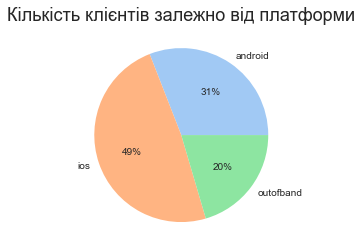

In [8]:
df_platform = df[['userid', 'event_platform']].drop_duplicates().dropna().groupby('event_platform')\
        .agg({'userid':'count'}).reset_index()

data = df_platform.userid
labels = df_platform.event_platform

colors = sns.color_palette('pastel')[ 0:5 ]

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title('Кількість клієнтів залежно від платформи', fontsize=18)
plt.show()

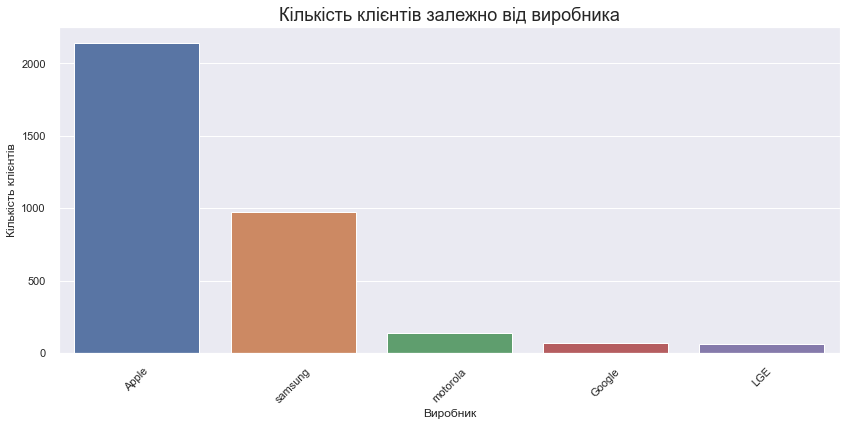

In [9]:
sns.set(rc={'figure.figsize':(14, 6)})
df_device = df[['userid', 'device_manufacture']].drop_duplicates().dropna().groupby('device_manufacture')\
        .agg({'userid':'count'}).reset_index().sort_values(by='userid', ascending=False).head()

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[ 0:5 ]

#create pie chart
sns.barplot(data = df_device, x=df_device.device_manufacture, y=df_device.userid)
plt.xticks(rotation=45)
plt.title('Кількість клієнтів залежно від виробника', fontsize=18)
plt.ylabel("Кількість клієнтів")
plt.xlabel("Виробник")
plt.show()

Text(0.5, 1.0, 'Кількість клієнтів по штатам')

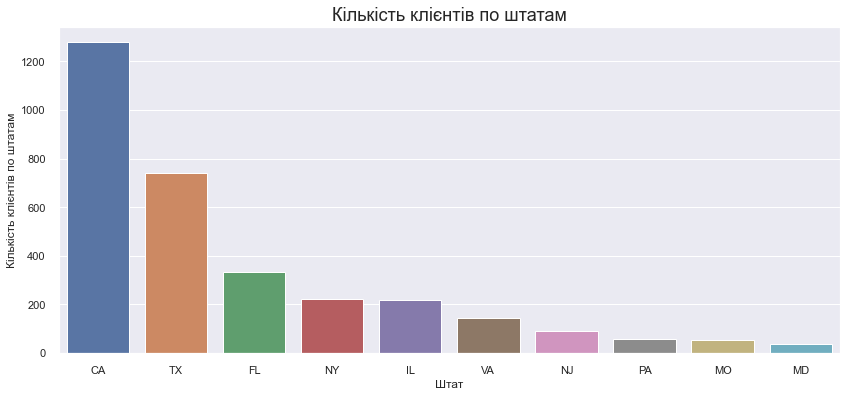

In [10]:
df_state = df[['userid', 'user_state']].drop_duplicates().dropna().groupby('user_state')\
.agg({'userid':'count'}).reset_index().sort_values(by='userid', ascending=False) 

sns.barplot(data = df_state, x=df_state.user_state.head(10), y=df_state.userid)
plt.ylabel("Кількість клієнтів по штатам")
plt.xlabel("Штат")
plt.title('Кількість клієнтів по штатам', fontsize=18)

Text(0.5, 1.0, 'Порівняння клієнтів, які відмінили підписку із загальною кількістю клієнтів')

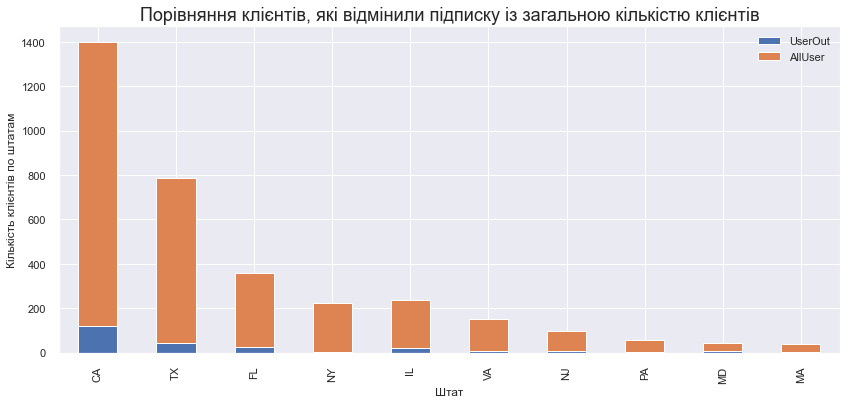

In [11]:
df_compare = pd.merge(df[['userid', 'user_state']].drop_duplicates().dropna().groupby('user_state')\
    .agg({'userid':'count'}).reset_index().sort_values(by='userid', ascending=False).\
                      rename(columns={'userid': 'AllUser'}),\
                      df[df.event_name == 'Subscription Premium Cancel']['user_state'].value_counts()\
    .reset_index().rename(columns={'user_state': 'UserOut', 'index': 'user_state'}), how='inner')

sns.set(rc={'figure.figsize':(14, 6)})
df_compare[['user_state', 'UserOut', 'AllUser']].head(10)\
    .plot(x='user_state', kind='bar', stacked= True)
plt.ylabel("Кількість клієнтів по штатам")
plt.xlabel("Штат")
plt.title('Порівняння клієнтів, які відмінили підписку із загальною кількістю клієнтів', fontsize=18)

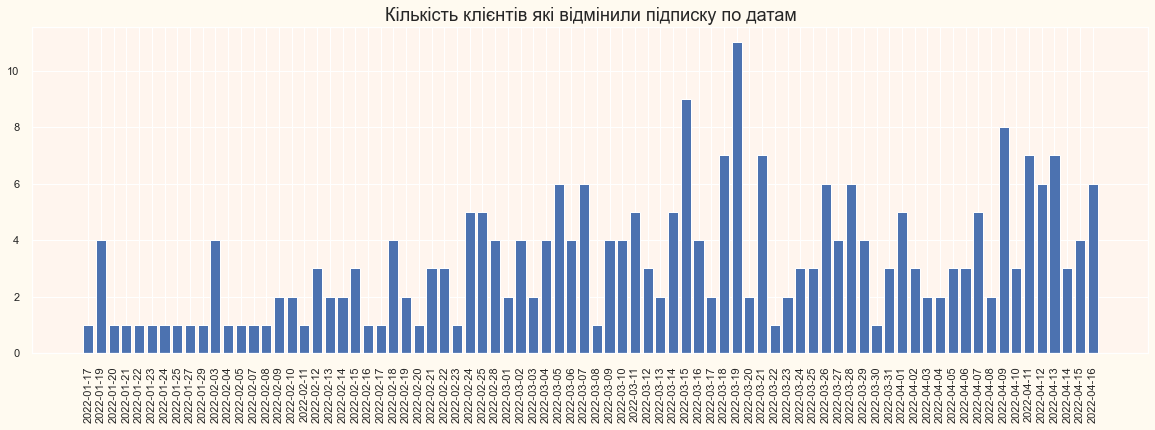

In [12]:
df_outers = df[df.event_name=='Subscription Premium Cancel']
df_outers.event_created_date = df_outers.event_created_date.astype("datetime64[ns]").dt.to_period("D")
df_outers = df_outers.groupby('event_created_date').agg({'userid':'count'}).reset_index()

x = np.array(df_outers.event_created_date.astype(str))
y1 = np.array(df_outers.userid)

fig, ax = plt.subplots()

ax.bar(x, y1)

ax.set_facecolor('seashell')
fig.set_figwidth(20)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
fig.set_facecolor('floralwhite')
plt.xticks(rotation=90)
plt.title('Кількість клієнтів які відмінили підписку по датам', fontsize=18)

plt.show()

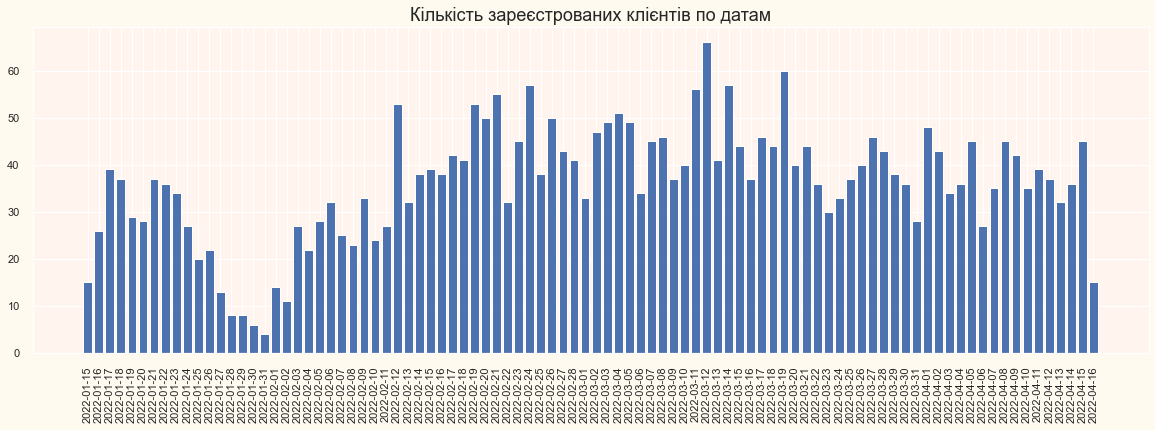

In [13]:
df_outers = df[df.event_name=='Sign Up Success']
df_outers.event_created_date = df_outers.event_created_date.astype("datetime64[ns]").dt.to_period("D")
df_outers = df_outers.groupby('event_created_date').agg({'userid':'count'}).reset_index()

x = np.array(df_outers.event_created_date.astype(str))
y1 = np.array(df_outers.userid)

fig, ax = plt.subplots()

ax.bar(x, y1)

ax.set_facecolor('seashell')
fig.set_figwidth(20)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
fig.set_facecolor('floralwhite')
plt.xticks(rotation=90)
plt.title('Кількість зареєстрованих клієнтів по датам', fontsize=18)

plt.show()

<b>Проаналізувавши графіки, з'явилась ідея використати кластеризацію даних, а потім додатково проаналізувати кластери, у яких є churned користувачі. З графіків можна зробити висновок, що event_name - основна метрика, яку слід використовувати.

In [14]:
df_for_scaller = df.copy()

In [15]:
df_for_scaller = df_for_scaller.groupby(['userid', 'event_name']).agg({'event_name': 'count'})\
    .rename(columns={'event_name': 'amount_event'}).unstack().fillna(0)['amount_event']\
    .reset_index()

In [16]:
df_for_scaller = df_for_scaller.drop(['userid'], axis=1)

In [17]:
df_for_scaller.head()

event_name,Account History Transaction Details,Account Setup Profile Skip,Account Setup Skip,Add Payment Method Failed,Add Payment Method Success,Add Vehicle Break,Add Vehicle Failed,Add Vehicle Success,Calculator Used,Calculator View,...,Order,Reset Password Set,Sign Out,Sign Up Error,Sign Up Success,Subscription Premium,Subscription Premium Cancel,Subscription Premium Renew,Transaction Refund,Wallet Opened
0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


<b>Зашкалимо дані використовуючи Standart Scaler

In [18]:
scaller = StandardScaler()
scaller.fit(df_for_scaller)
X = scaller.transform(df_for_scaller)

<b>Використаємо нестандартний підхід з використанням KElbowVisualizer для того, щоб дізнатись найкращу кількість кластерів для нас

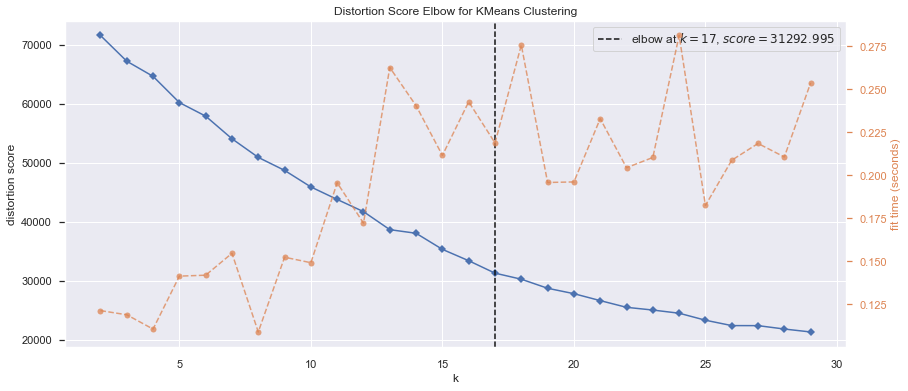

In [19]:
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k = (2, 30),
                              locate_elbow = True)
visualizer.fit(X)
visualizer.poof();

<b>З графіку бачимо, що оптимальна кількість кластерів 16

In [20]:
kmeansmodel = KMeans(n_clusters= 16, init='k-means++', random_state=512)

In [21]:
clusters = kmeansmodel.fit_predict(X)

<b>Зробимо прив'язку до кожної строки відповідного кластеру

In [22]:
df_for_scaller['NumberCluster'] = clusters
df = df_for_scaller

Text(0.5, 1.0, 'Кількість charned користувачів залежно від кластеру')

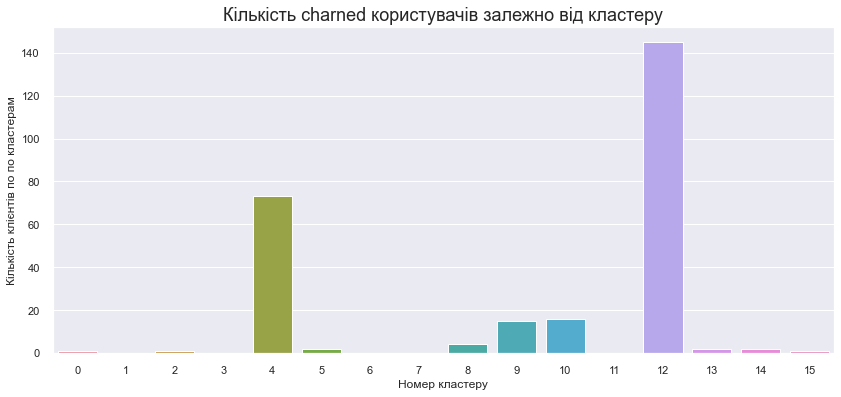

In [23]:
df_cancel = df[['Subscription Premium Cancel', 'NumberCluster']]\
    .sort_values(by='NumberCluster', ascending=False).groupby('NumberCluster')\
    .agg({'Subscription Premium Cancel':'sum'}).reset_index()

sns.barplot(data = df_cancel, x=df_cancel.NumberCluster, y=df_cancel['Subscription Premium Cancel'])
plt.ylabel("Кількість клієнтів по по кластерам")
plt.xlabel("Номер кластеру")
plt.title('Кількість charned користувачів залежно від кластеру', fontsize=18)

<b> Основна кількість charned користувачів у 4 та 12 кластері, тому розглянемо їх

Text(0.5, 1.0, "Кількість подій пов'язаних з charned користувачами")

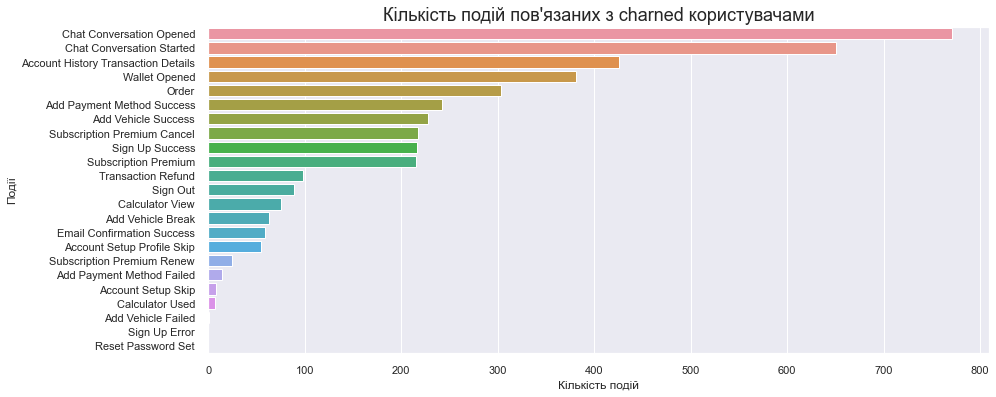

In [24]:
df_info = df[(df.NumberCluster == 4) | (df.NumberCluster == 12)]
df_info_events = df_info.drop('NumberCluster', axis=1).sum().reset_index()\
    .rename(columns={0: 'amount_events'}).sort_values(by='amount_events', ascending=False)

sns.barplot(data = df_info_events, x=df_info_events.amount_events, y=df_info_events.event_name)
plt.ylabel("Події")
plt.xlabel("Кількість подій")
plt.title("Кількість подій пов'язаних з charned користувачами", fontsize=18)


<b> За графіком бачимо, що користувачі, які відмінили підписку, часто перевіряють баланс та історію транзакцій, а потім звертаються за допомогою. Звідси робимо висновок, що в більшості випадків люди відміняють підписку, коли мають технічні проблеми з оплатою послуг в додатку.

## Результат

Отже, ми виявили, що більша частина користувачів має ios платформу, тому для початку потрібно перевірити чи коректно працює додаток на цій платформі. Також було порівняно клієнтів, які відмінили підписку, із загальною кількістю клієнтів, де побачили, що штат не впливає на відсоток відписок. 2022-01-31 було рекордно мале значення зареєстрованих користувачів у цю дату, але потім їх кількість почала значно зростати разом із charned користувачами. На основі інформації з графіків було прийнято рішення використати кластеризацію даних, беручи до уваги лише метрику event_name. 
    
Опрацювавши дані, було створено 16 кластерів, серед яких нас цікавлять кластери 4 та 12, тому що вони виділяються кількістю charned користувачів. Проаналізувавши 2 кластери, було виявлено, що користувачі, які відмінили підписку, часто перевіряють баланс та історію транзакцій, а потім звертаються за допомогою. Це свідчить про те, що в більшості випадків люди відміняють підписку, коли мають технічні проблеми з оплатою послуг в додатку.

<b>Мої рекомендації:
<li> Задля запобігання відтоку клієнтів варто переглянути чи інтуїтивно зрозуміло побудований додаток
<li> Створити додаткове спливаюче вікно, де потрібно зробити "фінальне" підтвердження оплати
<li> Перевірити чи чат допомоги дійсно працює і вирішує проблеми користувачів
 